# EDA To Prediction (DieTanic)

- source: <https://www.kaggle.com/ash316/eda-to-prediction-dietanic>

Part 1: Exploratory Data Analysis (EDA)
- Analysis of the features
- Finding any relations of trends considering multiple features

Part 2: Feature Engineering and Data Cleaning
- Adding any few features
- Removing redundant features
- Converting features into suitable form for modeling

Part 3: Predictive Modeling
- Running Basic Algorithms
- Cross Validation
- Ensembling
- Important Features Extraction

In [1]:
import zipfile
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
sns.set(font_scale=1.5)
%matplotlib inline

# Part 1: Exploratory Data Analysis (EDA)

In [3]:
with zipfile.ZipFile("titanic.zip", "r") as zipf:
    with zipf.open("train.csv") as f:
        data = pd.read_csv(f)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin, Embarked는 실제로 NaN 값이 존재

### How many Survived

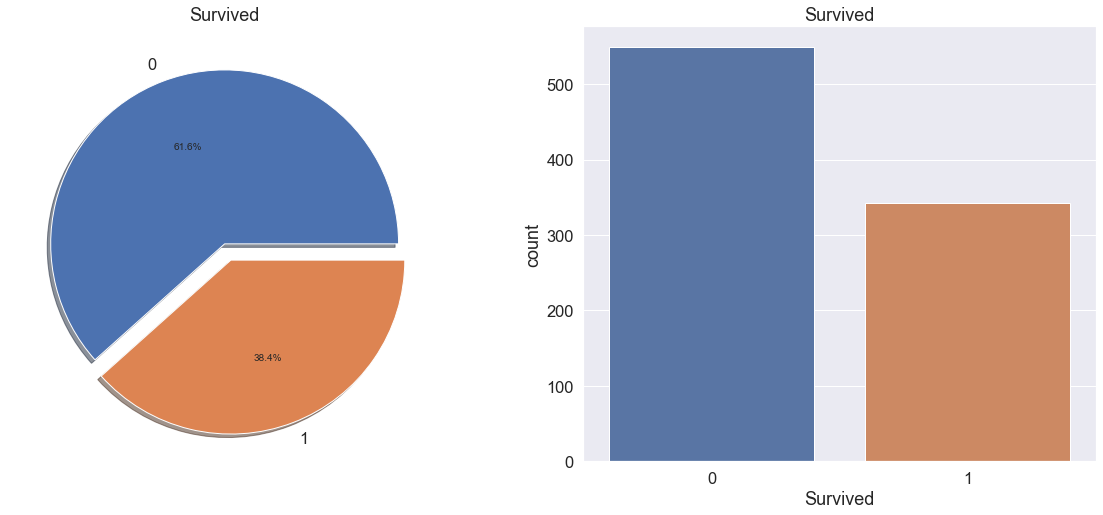

In [9]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data.Survived.value_counts().plot.pie(explode=(0, 0.1), autopct="%1.1f%%", ax=ax[0], shadow=True)
sns.countplot("Survived", data=data, ax=ax[1])

ax[0].set_ylabel("")
for i in range(2):
    ax[i].set_title("Survived")

plt.show()

### Types of Features

- Categorical Variable: Sex, Embarked
- Ordinal Variable: Pclass
- Countinuous Variable: Age

## Analysing The Features

### Sex -> Categorical Feature

In [10]:
data.groupby(["Sex", "Survived"])["Survived"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

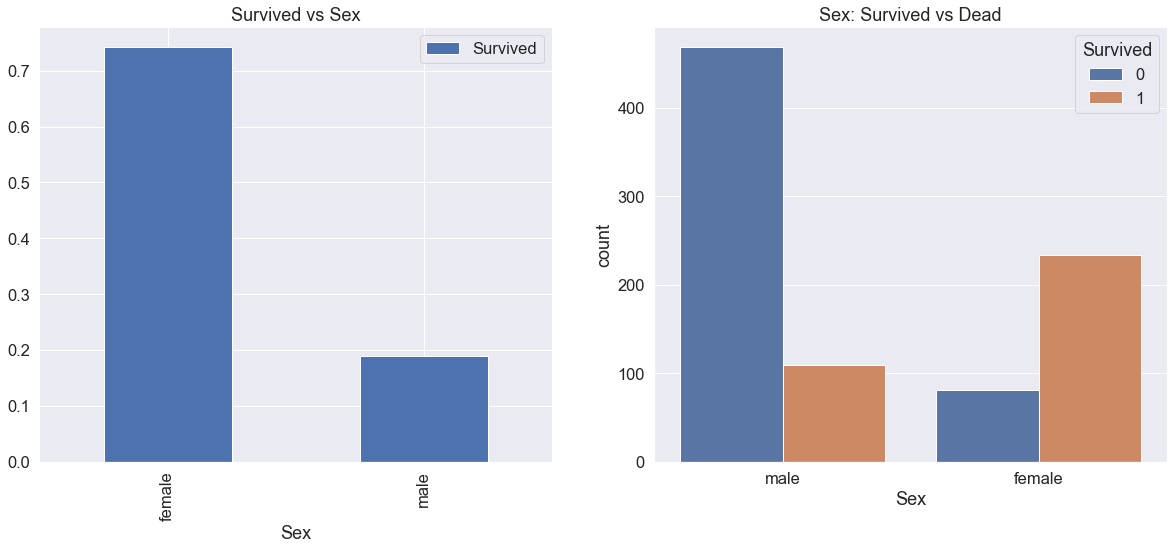

In [13]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data[["Sex", "Survived"]].groupby(["Sex"]).mean().plot.bar(ax=ax[0])
sns.countplot("Sex", hue="Survived", data=data)

ax[0].set_title("Survived vs Sex")
ax[1].set_title("Sex: Survived vs Dead")

plt.show()

여성의 생존율이 남성보다 높은 편이다. 이는 성별에 따른 count 생존율, 사망율을 보면 더 확실하게 알 수 있다.

### Pclass -> Ordinal Feature

In [14]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap="summer_r")

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Pclass별 생존율. 1 클래스의 생존율이 높으며, 3 클래스의 사망율이 높다.

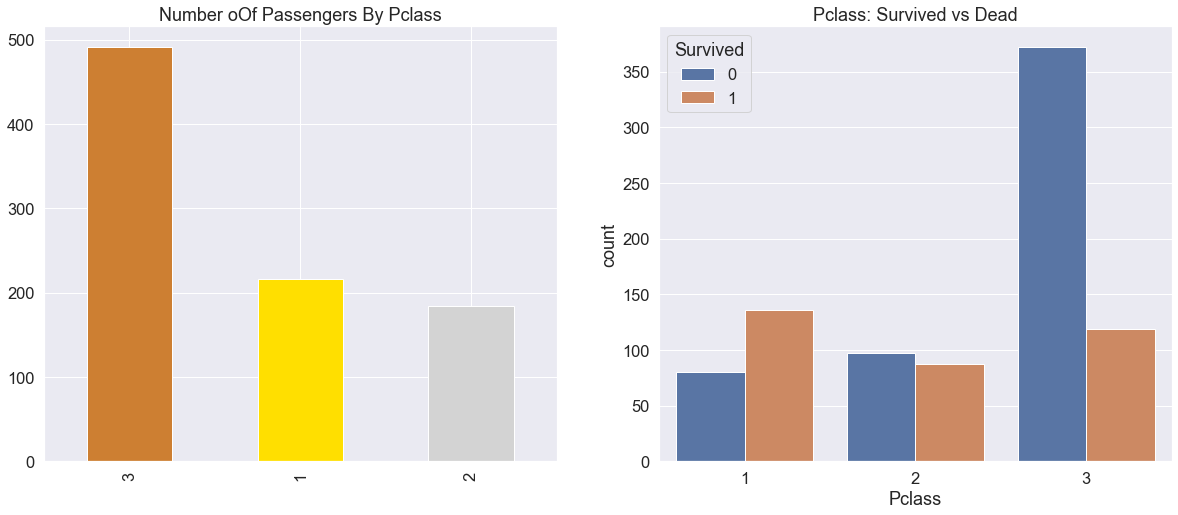

In [15]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data.Pclass.value_counts().plot.bar(color=["#CD7F32", "#FFDF00", "#D3D3D3"], ax=ax[0])
sns.countplot("Pclass", hue="Survived", data=data)

ax[0].set_title("Number oOf Passengers By Pclass")
ax[1].set_title("Pclass: Survived vs Dead")

plt.show()

3 class에 사람이 많았다. 그러나 생존율은 낮았지. 전체 생존율이 낮았으니 어쩌면 사람이 많은 것에 대한 반동일 수도.<br />
라고 생각하고 싶었지만, Pclass별 생존율의 차이가 있는 듯하다. class의 숫자가 작을수록 생존율은 높았다.<br />
되도록이면 알고 싶지 않았지만, Pclass는 정말 등급이었나보다. 이 물질만능주의 사회 같으니라고.

In [17]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap="summer_r")

초록색일수록 값이 크다. Pclass와 Pclass의 숫자는 비례한다. 남성일수록 기울기의 값이 크다.

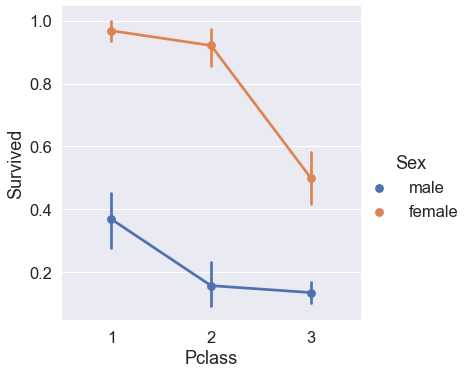

In [18]:
sns.factorplot("Pclass", "Survived", hue="Sex", data=data)
plt.show()

Pclass별 여성의 생존율은 남성의 2배 이상을 웃돌기도 한다.<br />
게다가 1 class의 여성은 생존율이 굉장히 높다. 신기한 건 1 class의 남성보다 2 class, 3 class의 여성의 생존율이 더 높다는 점이다. 완벽한 물질만능주의 사회는 아닌가 보다.

### Age -> Continuous Feature

In [19]:
print(f"가장 나이가 많아요: {data.Age.max()} years",
      f"가장 나이가 어려요: {data.Age.min()} years",
      "평균 나이는 이래요: {:.2f}".format(data.Age.mean()), sep="\n")

가장 나이가 많아요: 80.0 years
가장 나이가 어려요: 0.42 years
평균 나이는 이래요: 29.70


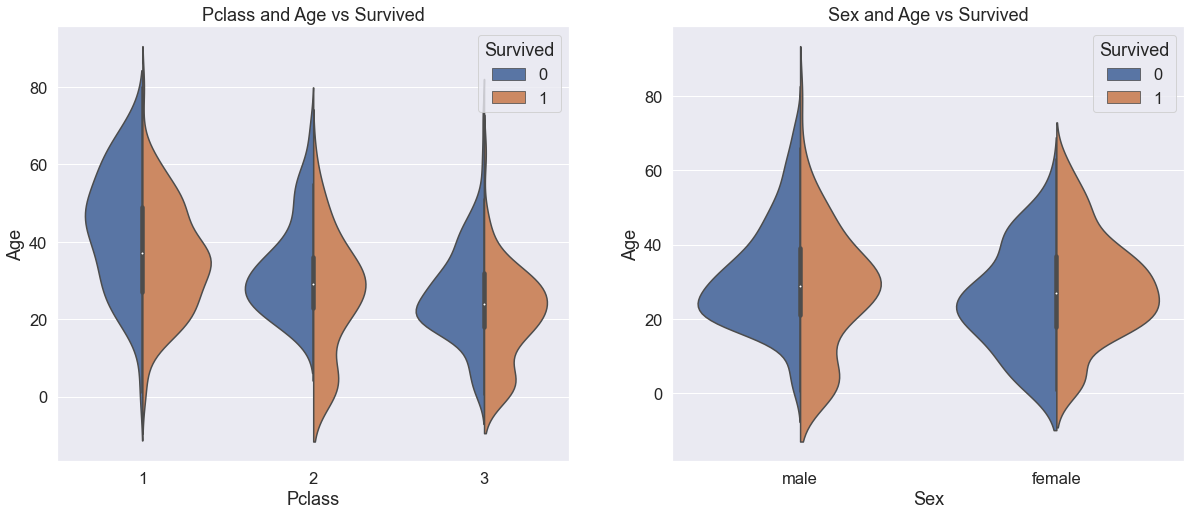

In [23]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True)
# split: hue로 나눠진 그림의 단면을 붙인다.

ax[0].set_title("Pclass and Age vs Survived")
ax[1].set_title("Sex and Age vs Survived")

plt.show()

x와 y에 대한 확률분포까지 확인할 수 있다지만, 확실히 난 violinplot이 눈에 잘 들어오는 것 같진 않다.

- Pclass의 숫자가 작을수록 대체로 나이가 많다.
- Pclass의 숫자가 클수록 나이가 어려지는 경향이 있다.
- 생존율에 대한 분포의 위치는 모든 class가 비슷하다.
- 2 class에서 생존율에 대한 나이 분포가 가장 넒은 range를 가지지만, 1 class의 분포가 많이 뚱뚱한 걸 보면 2 class가 나이에 상관없이 고루 생존율이 높다고 얘기하긴 어렵다고 본다.
- 남성, 여성 모두 (현재 시점의) 사회 초년생 ~ 사회인의 사망율(쉽게 말해 그림에서 20 ~ 40의 사망율)이 높다. 가장 많이 타고 있었다고 생각되는 나이대라서 그런 듯하다.

#### "What's In A Name??" ----> Feature :p

In [26]:
data.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [24]:
data["Initial"] = data.Name.str.extract("([A-Za-z]+)\.")

In [25]:
pd.crosstab(data.Sex, data.Initial).style.background_gradient(cmap="summer_r")

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [27]:
data["Initial"].replace([
    "Mlle", "Mme", "Ms", "Dr", "Major", "Lady", "Countess",
    "Jonkheer", "Col", "Rev", "Capt", "Sir", "Don"], [
    "Miss", "Miss", "Miss", "Mr", "Mr", "Mrs", "Mrs",
    "Other", "Other", "Other", "Mr", "Mr", "Mr"], inplace=True)

In [29]:
data.groupby("Initial")["Age"].agg(["count", "mean"])

,count,mean
Initial,,
Master,36,4.574167
Miss,150,21.860000
Mr,409,32.739609
Mrs,110,35.981818
Other,9,45.888889


#### Filling NaN Ages

In [35]:
for i in ["Mr", "Mrs", "Master", "Miss", "Other"]:
    data.loc[data.Age.isnull() & (data.Initial == i), "Age"] = int(round(data.loc[data.Initial == i, "Age"].mean(), 0))

In [37]:
data.Age.isnull().any()

False

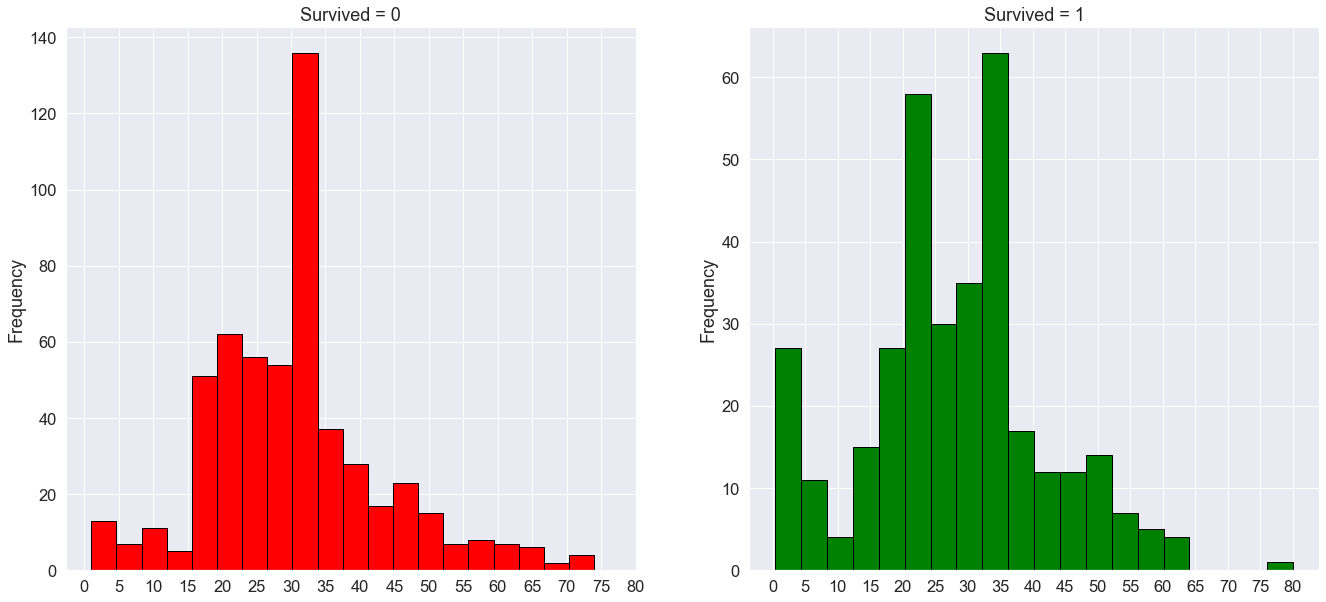

In [39]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

data[data.Survived == 0].Age.plot.hist(bins=20, color="red", edgecolor="black", ax=ax[0])
data[data.Survived == 1].Age.plot.hist(bins=20, color="green", edgecolor="black")

ax[0].set_xticks(list(range(0, 85, 5)))
ax[1].set_xticks(list(range(0, 85, 5)))
ax[0].set_title("Survived = 0")
ax[1].set_title("Survived = 1")

plt.show()

- 죽은 사람의 나이 최빈값이나 산 사람의 나이 최빈값이나 비슷하다?
- 죽은 사람의 분포는 첨도가 큰 분포라면, 산 사람의 분포는 왼쪽 꼬리가 두꺼운 분포이다. 즉, 골고루 살았다?
- 상당히 10세 미만의 어린이가 많다. 가족끼리 탑승한 경우가 많았나보다.

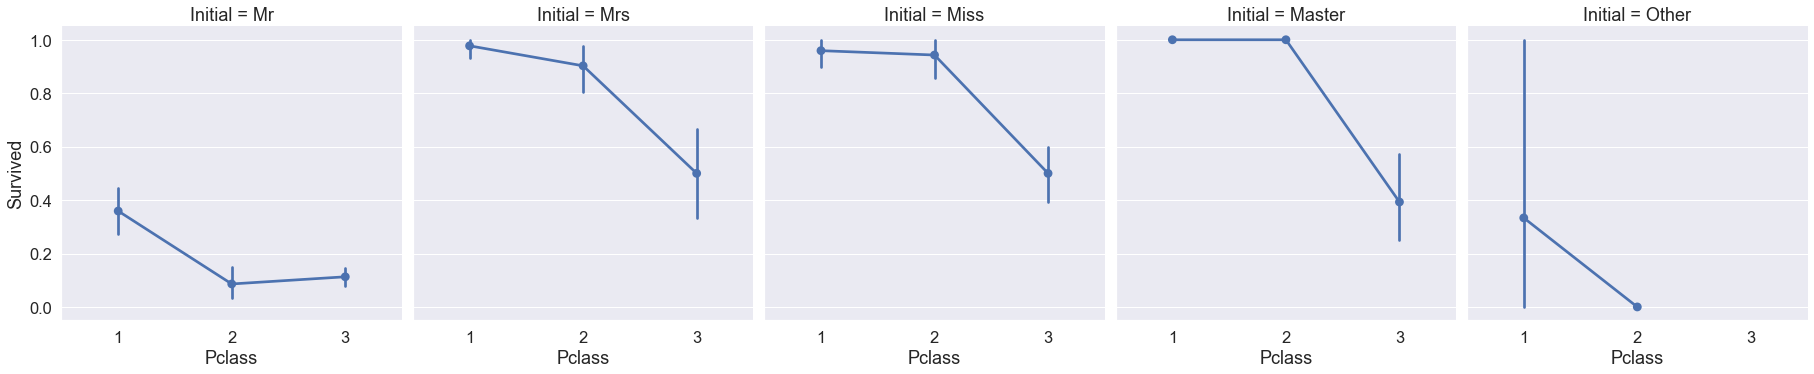

In [44]:
sns.factorplot("Pclass", "Survived", col="Initial", data=data) # row="Initial"
plt.show()

- 어린 아이를 지칭하는 것으로 보였던 Other는 class의 숫자가 작은 쪽에 몰려있다. 어린아이들은 대체로 살았다는 얘기가 되어 다행이다.
- 모든 Initial에 대하여 Pclass의 숫자가 클수록 생존율이 낮아진다. 물질만능주의..

### Embarked -> Categorical Value

In [45]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient(cmap="summer_r")

- 확실히 여성의 생존율이 높다.
- 근데 Q 항구를 통한 3 class 여성 탑승객의 생존율이 다른 항구에 비해 높은 것으로 보인다?
- Q 항구의 탑승객의 객실 위치가 초기 침몰 지점의 반대쪽이거나 구출 지점에 가까운 건가?

#### Chances for Survival by Port Of Embarkation

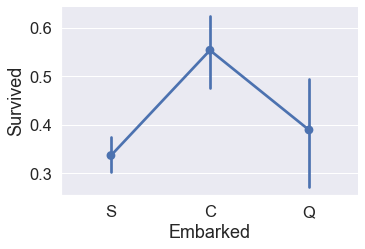

In [52]:
sns.factorplot("Embarked", "Survived", data=data)
plt.gcf().set_size_inches(5, 3) # plt.figure(figsize)로 조절하려고 했으나 안 됐음.
plt.show()

C 항구에 대한 생존율이 높다.

- 항구와 성별 or 항구와 Pclass 간의 관계가 있다고 보여진다.

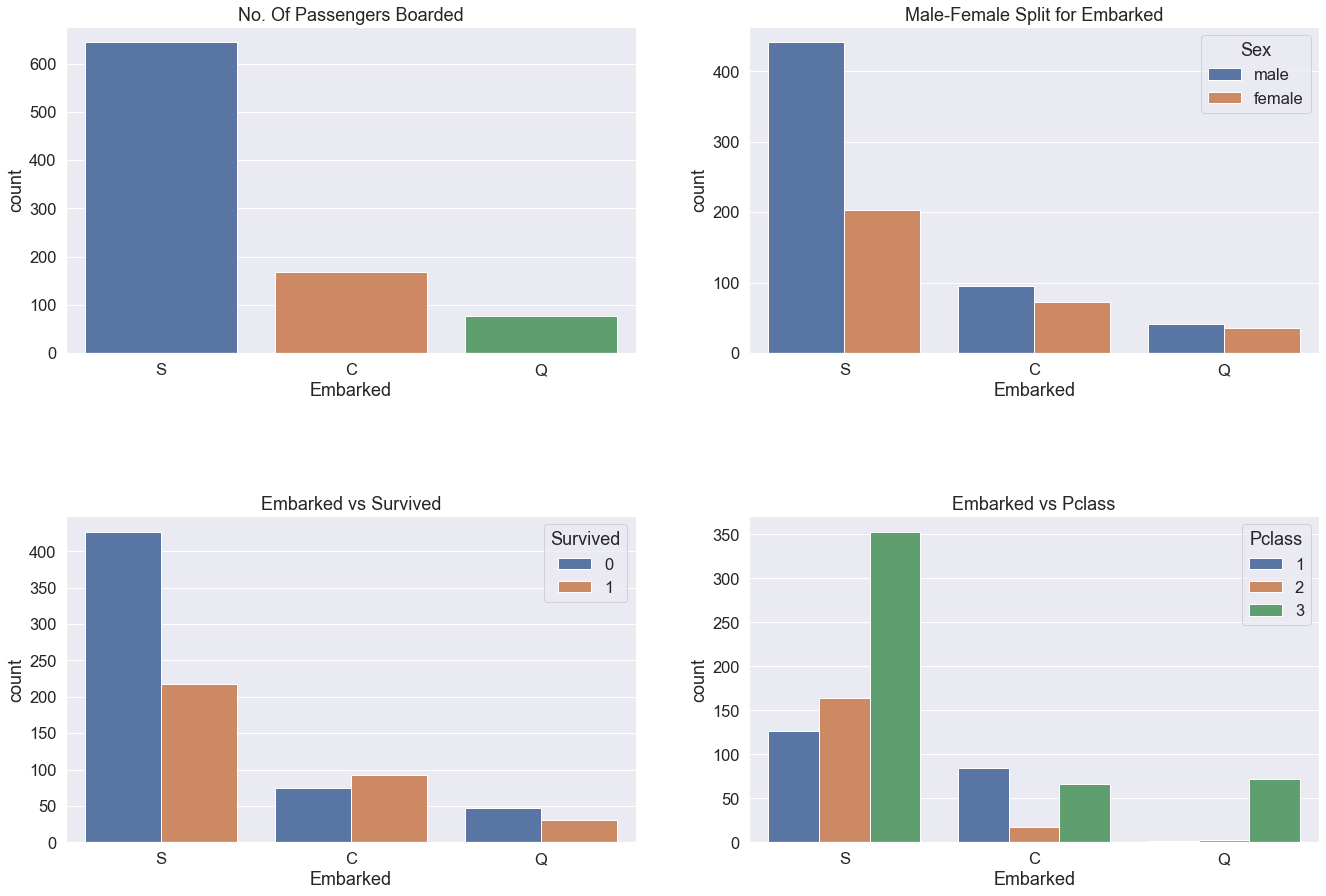

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot("Embarked", data=data, ax=ax[0, 0])
sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
sns.countplot("Embarked", hue="Pclass", data=data)

ax[0, 0].set_title("No. Of Passengers Boarded")
ax[0, 1].set_title("Male-Female Split for Embarked")
ax[1, 0].set_title("Embarked vs Survived")
ax[1, 1].set_title("Embarked vs Pclass")

plt.subplots_adjust(wspace=.2, hspace=.5)
plt.show()

- S 항구를 통해 탑승한 사람이 제일 많다. (S > C > Q)
- 그래서 사망율 또한 높다.
- Embarked와 Sex는 큰 관련이 없다. 그냥 S 항구에서 탄 사람 중에 남성의 비율이 높을 뿐.
- S 항구는 그냥 대중적인 항구인가 보다. 여러 사람이 많이 탔네.
- C 항구의 생존율이 사망율보다 높다. 1 class의 사람이 많았거나, 여성이 많았거나.

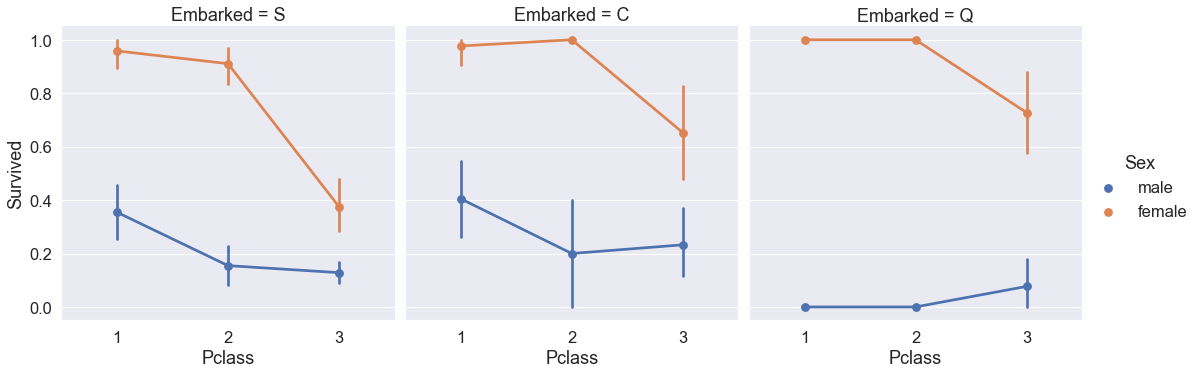

In [58]:
sns.factorplot("Pclass", "Survived", hue="Sex", col="Embarked", data=data)
plt.show()

- 모든 항구에 대해서 Pclass의 숫자가 작을수록 생존율이 높다.
- 모든 항구에 대해서 여성의 생존율은 3 class만 아니면 상당히 높다.
- 간만에 3 class에 대한 생존율이 높은가 했더니 Q 항구에선 극소수 말고는 3 class의 사람만 탔으니, 생존율이 높게 나올 수밖에.

#### Filling Embarked NaN

In [59]:
data["Embarked"].fillna("S", inplace=True)

In [60]:
data.Embarked.isnull().any()

False

### SibSp -> Discrete Feature

In [63]:
pd.crosstab(data.SibSp, data.Survived).style.background_gradient(cmap="summer_r")

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


형제가 없을수록 생존율 향상의 도움이 된다. 아마 서로 챙기느라 제때 탈출하지 못한 것으로 보인다.

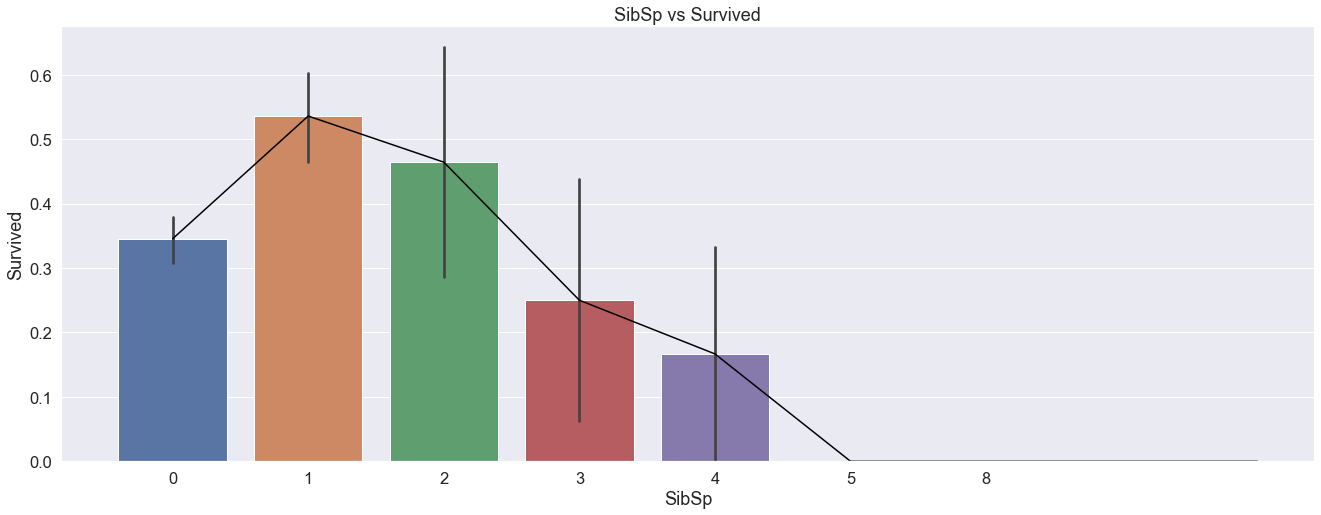

In [83]:
plt.figure(figsize=(20, 8))

sns.barplot("SibSp", "Survived", data=data)
plt.plot(data[["SibSp", "Survived"]].groupby("SibSp")["Survived"].mean(), c="black")
# sns.factorplot("SibSp", "Survived", data=data)

plt.title("SibSp vs Survived")
plt.show()